In [1]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from nltk.corpus import stopwords #Useful for getting a list of stopwords 
import math
from scipy import spatial
!pip install ipython-autotime

%load_ext autotime

time: 2.8 ms (started: 2021-05-05 14:39:21 +00:00)


In [2]:
! pip install rank_bm25
import nltk 
import string 
import re 
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

time: 3.72 s (started: 2021-05-05 14:39:33 +00:00)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 33.2 s (started: 2021-05-05 14:39:51 +00:00)


In [4]:
from rank_bm25 import BM25Okapi
dataset2 = pd.read_csv('/content/drive/MyDrive/IR Project/dataset_with_details_wikivoyage.csv')
dataset1 = pd.read_csv('/content/drive/MyDrive/IR Project/final_dataset_wo_duplicates.csv')

time: 2.4 s (started: 2021-05-05 14:40:29 +00:00)


In [5]:
dataset2.to_csv('wiki_voyage_correct.csv',index=False)

time: 198 ms (started: 2021-05-05 14:40:36 +00:00)


In [6]:
cites = list(dataset1['City'])

time: 3.26 ms (started: 2021-05-05 14:40:45 +00:00)


In [7]:
document_list=[]
lemmatizer = WordNetLemmatizer() 
i=0
cities = dataset2['City']
for i in range(dataset2.shape[0]):
  k= cities[i]
  document = ' description of '+ k + dataset2.iloc[i]['description']+'Places to visit in '+k  +str(dataset2.iloc[i]['sites']) + '\n how to reach '+ k+str(dataset2.iloc[i]['how to reach']) + '\n best time to visit'+k+dataset2.iloc[i]['best to time visit'] + dataset2.iloc[i]['wiki voyage']
  document = document.lower()
  input_str = document
  translator = str.maketrans('', '', string.punctuation) 
  document = document.translate(translator) 
  # document=lemmatizer.lemmatize(document)
  tokens = document.split()
  tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stopwords.words('english')]
  text = ' '.join(tokens)
  document_list.append(text)
  i+=1

time: 2min 52s (started: 2021-05-05 14:40:48 +00:00)


In [8]:
len(document_list)

286

time: 8.78 ms (started: 2021-05-05 14:43:45 +00:00)


In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(document_list)


time: 802 ms (started: 2021-05-05 14:43:49 +00:00)


In [10]:
vocab = vectorizer.vocabulary_
idf_values = vectorizer.idf_

time: 2.99 ms (started: 2021-05-05 14:43:57 +00:00)


In [ ]:
query=input('Enter the query')
query=query.lower()
query = query.translate(translator)
tokens = query.split()
tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stopwords.words('english')]
text = ' '.join(tokens)
query_vector = np.zeros((X.shape[1]))
for t in tokens:
  try:
    # print(t)
    t_index = vocab[t]
    query_vector[t_index]= query_vector[t_index] + idf_values[t_index]
    print(t)
  except:
    pass



Enter the queryhill station
hill
station
time: 4.03 s (started: 2021-04-23 07:19:27 +00:00)


In [ ]:
scores_array=np.zeros((len(document_list),))
dense = X.toarray()
print('Using raw count')
for i in range(len(document_list)):
  # print(i)
  doc_vector = dense[i,:]
  result = 1 - spatial.distance.cosine(doc_vector, query_vector)
  scores_array[i]=result

top5=scores_array.argsort()[-10:][::-1]
for i in top5:
  print(scores_array[i],cities[i])
print()

Using raw count
0.12040693564241722 Baghmara
0.1165131362175672 Roing
0.11650732775747863 Jowai
0.11286742442928688 Williamnagar
0.10970439973610868 Vagamon
0.10616732459987366 Nongpoh
0.1047765759542767 Ooty
0.10171243015763731 Nelliyampathy
0.09874142864736613 Shoghi
0.09498387529942742 Pauri Garhwal

time: 194 ms (started: 2021-04-23 07:19:33 +00:00)


In [12]:
X.shape[1]

53255

time: 14.3 ms (started: 2021-05-05 14:44:13 +00:00)


In [11]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
keras.backend.clear_session()
encoding_dim = 53255


time: 1.51 s (started: 2021-05-05 14:44:08 +00:00)


In [ ]:
input_img = keras.Input(shape=(53255,))
keras.backend.clear_session()
encoded = layers.Dense(8000, activation='relu')(input_img)
encoded = layers.Dense(3000, activation='relu')(encoded)

encoded = layers.Dense(1000, activation='relu')(encoded)
encoded = layers.Dense(100, activation='relu')(encoded)
# encoded = layers.Dense(150, activation='relu')(encoded)



decoded = layers.Dense(1000, activation='relu')(encoded)
decoded = layers.Dense(3000, activation='relu')(decoded)
decoded = layers.Dense(8000, activation='relu')(decoded)
decoded = layers.Dense(53255, activation='relu')(decoded)

encoder = keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# # Retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # Create the decoder model
# decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

time: 3.28 s (started: 2021-04-22 19:15:03 +00:00)


In [13]:
dense = X.toarray()

x_train_1 = np.float32(dense)


time: 99.4 ms (started: 2021-05-05 14:44:34 +00:00)


In [ ]:
autoencoder.fit(x_train_1, x_train_1,
                epochs=50,
                batch_size=4,
                shuffle=True)

Epoch 1/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4796e-06
Epoch 2/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4809e-06
Epoch 3/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4794e-06
Epoch 4/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4686e-06
Epoch 5/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4644e-06
Epoch 6/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4615e-06
Epoch 7/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4694e-06
Epoch 8/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4733e-06
Epoch 9/50
72/72 [==============================] - 7s 97ms/step - loss: 8.4719e-06
Epoch 10/50
53/72 [=====================>........] - ETA: 1s - loss: 8.4369e-06

KeyboardInterrupt: ignored

time: 1min 8s (started: 2021-04-22 19:29:59 +00:00)


In [ ]:
autoencoder.save("/content/drive/MyDrive/ir_project/model1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ir_project/model1/assets
time: 2min 8s (started: 2021-04-22 19:32:51 +00:00)


In [ ]:
encoder.save("/content/drive/MyDrive/ir_project/model2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ir_project/model2/assets
time: 13.8 s (started: 2021-04-22 19:35:35 +00:00)


In [14]:
encoder = keras.models.load_model('/content/drive/MyDrive/ir_project/model2')

time: 53.2 s (started: 2021-05-05 14:44:50 +00:00)


In [15]:
X_encoded = encoder.predict(x_train_1)

time: 3.27 s (started: 2021-05-05 14:45:52 +00:00)


In [16]:
query=input('Enter the query')
query=query.lower()
query = query.translate(translator)
tokens = query.split()
tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stopwords.words('english')]
text = ' '.join(tokens)
query_vector = np.zeros((X.shape[1]))
for t in tokens:
  try:
    # print(t)
    t_index = vocab[t]
    query_vector[t_index]= query_vector[t_index] + idf_values[t_index]
    print(t)
  except:
    pass

Enter the queryharidwar
haridwar
time: 5.55 s (started: 2021-05-05 14:46:50 +00:00)


In [17]:
scores_array=np.zeros((len(document_list),))
dense = X.toarray()
print('Using raw count')
for i in range(len(document_list)):
  # print(i)
  doc_vector = dense[i,:]
  result = 1 - spatial.distance.cosine(doc_vector, query_vector)
  scores_array[i]=result
top5=scores_array.argsort()[-20:][::-1]
for i in top5:
  print(scores_array[i],cities[i])
print()

Using raw count
0.7534599524304002 Haridwar
0.14669350924211533 Kanchula Korak Musk Deer Sanctuary
0.1368456734890755 Champawat
0.13189075837568753 Tungnath
0.12660035025763816 Chopta
0.10650256609965736 Joshimath
0.09646786806000474 Rishikesh
0.0652633687530837 Auli
0.04625786840926449 Manikaran
0.0413104997749717 Gangotri
0.03688290626983526 Dehradun
0.03294661163022794 Kedarnath
0.027404699706125135 New Tehri
0.025984758352328607 Kasol
0.024890264391781436 Chamoli
0.02401736895867257 Yamunotri
0.0157610832395092 Mukteshwar
0.011532716038968105 Almora
0.010981293118946134 Badrinath
0.009916252812515625 Kanatal

time: 209 ms (started: 2021-05-05 14:47:00 +00:00)


In [18]:
query_vec = query_vector.reshape(1,X.shape[1])
query_encoded = encoder.predict(query_vec)
query_encoded = query_encoded.reshape(100,)

time: 80.6 ms (started: 2021-05-05 14:47:14 +00:00)


In [19]:
scores_array=np.zeros((len(document_list),))
dense = X.toarray()
print('Using raw count')
for i in range(len(document_list)):
  # print(i)
  doc_vector = X_encoded[i,:]
  result = 1 - spatial.distance.cosine(doc_vector, query_encoded)
  scores_array[i]=result
top5=scores_array.argsort()[-20:][::-1]
for i in top5:
  print(scores_array[i],cities[i])
print()

Using raw count
0.9810256361961365 Haridwar
0.8732166886329651 Joshimath
0.8686885833740234 Champawat
0.8640422224998474 Rishikesh
0.8480963110923767 Dehradun
0.8434915542602539 Manikaran
0.8420507907867432 Pithoragarh
0.8418795466423035 Gangotri
0.8378611207008362 Ujjain
0.832930862903595 Kanchula Korak Musk Deer Sanctuary
0.8316746354103088 Kedarnath
0.8271212577819824 Tungnath
0.8126929402351379 Chopta
0.8064330816268921 Varanasi
0.8035234212875366 Kausani
0.8014894127845764 Ahmedabad
0.8010725378990173 Dwarka
0.7989937663078308 Raipur
0.7987330555915833 Mandi
0.7975603342056274 Badrinath

time: 81.7 ms (started: 2021-05-05 14:47:19 +00:00)


In [ ]:
query=input('Enter the city 1')
query=query.lower()
query = query.translate(translator)
tokens = query.split()
tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stopwords.words('english')]
text = ' '.join(tokens)
query_vector_1 = np.zeros((X.shape[1]))
for t in tokens:
  try:
    # print(t)
    t_index = vocab[t]
    query_vector_1[t_index]= query_vector[t_index] + idf_values[t_index]
    print(t)
  except:
    pass


query=input('Enter the city 1')
query=query.lower()
query = query.translate(translator)
tokens = query.split()
tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stopwords.words('english')]
text = ' '.join(tokens)
query_vector_2 = np.zeros((X.shape[1]))
for t in tokens:
  try:
    # print(t)
    t_index = vocab[t]
    query_vector_2[t_index]= query_vector[t_index] + idf_values[t_index]
    print(t)
  except:
    pass

query=input('Enter the city 1')
query=query.lower()
query = query.translate(translator)
tokens = query.split()
tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stopwords.words('english')]
text = ' '.join(tokens)
query_vector_3 = np.zeros((X.shape[1]))
for t in tokens:
  try:
    # print(t)
    t_index = vocab[t]
    query_vector_3[t_index]= query_vector[t_index] + idf_values[t_index]
    print(t)
  except:
    pass

Enter the city 1hills
hill
Enter the city 1snow
snow
Enter the city 1beaches
beach
time: 12 s (started: 2021-04-23 07:25:45 +00:00)


array([0., 0., 0., ..., 0., 0., 0.])

time: 7.5 ms (started: 2021-04-23 07:19:01 +00:00)


In [ ]:
result = 1 - spatial.distance.cosine(query_vector_1, query_vector_2)
print(result)

0.0
time: 4.25 ms (started: 2021-04-23 07:26:02 +00:00)


In [ ]:
query_vector_1 = query_vector_1.reshape(1,X.shape[1])
query_encoded_1 = encoder.predict(query_vector_1)
query_encoded_1 = query_encoded_1.reshape(100,)

query_vector_2 = query_vector_2.reshape(1,X.shape[1])
query_encoded_2 = encoder.predict(query_vector_2)
query_encoded_2 = query_encoded_2.reshape(100,)

query_vector_3 = query_vector_3.reshape(1,X.shape[1])
query_encoded_3 = encoder.predict(query_vector_3)
query_encoded_3 = query_encoded_3.reshape(100,)

result = 1 - spatial.distance.cosine(query_encoded_1, query_encoded_2)
print('Similarity between city 1 and city 2',result)

result = 1 - spatial.distance.cosine(query_encoded_1, query_encoded_3)
print('Similarity between city 1 and city 3',result)

result = 1 - spatial.distance.cosine(query_encoded_2, query_encoded_3)
print('Similarity between city 2 and city 3',result)

Similarity between city 1 and city 2 0.9090009331703186
Similarity between city 1 and city 3 0.593808650970459
Similarity between city 2 and city 3 0.6269001960754395
time: 220 ms (started: 2021-04-23 07:26:05 +00:00)


In [20]:
# queries=['hills','snow','mountains','beach','sea','wildlife','lion','tiger','malls','market','temple','ganga','pilgrimage','fort','history']

queries=['haridwar','rishikesh','kedarnath','chandigarh','delhi','agra','mumbai','kullu','manali','coorg','munnar','coonoor','ooty','alleppey','alibaug']

time: 2.76 ms (started: 2021-05-05 14:48:11 +00:00)


In [21]:
similarity_scores = np.zeros((len(queries),len(queries)))
for i in range(len(queries)):
  for j in range(len(queries)):
    query=queries[i]
    query = query.translate(translator)
    tokens = query.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stopwords.words('english')]
    text = ' '.join(tokens)
    query_vector_1 = np.zeros((X.shape[1]))
    for t in tokens:
      try:
        # print(t)
        t_index = vocab[t]
        query_vector_1[t_index]= query_vector[t_index] + idf_values[t_index]
        print(t)
      except:
        pass


    query=queries[j]
    query=query.lower()
    query = query.translate(translator)
    tokens = query.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stopwords.words('english')]
    text = ' '.join(tokens)
    query_vector_2 = np.zeros((X.shape[1]))
    for t in tokens:
      try:
        # print(t)
        t_index = vocab[t]
        query_vector_2[t_index]= query_vector[t_index] + idf_values[t_index]
        print(t)
      except:
        pass

    query_vector_1 = query_vector_1.reshape(1,X.shape[1])
    query_encoded_1 = encoder.predict(query_vector_1)
    query_encoded_1 = query_encoded_1.reshape(100,)

    query_vector_2 = query_vector_2.reshape(1,X.shape[1])
    query_encoded_2 = encoder.predict(query_vector_2)
    query_encoded_2 = query_encoded_2.reshape(100,) 

    result = 1 - spatial.distance.cosine(query_encoded_1, query_encoded_2)
    print('Similarity between',queries[i],' ',queries[j],' : ',result)
    similarity_scores[i,j]=result


haridwar
haridwar
Similarity between haridwar   haridwar  :  1.0
haridwar
rishikesh
Similarity between haridwar   rishikesh  :  0.7703390717506409
haridwar
kedarnath
Similarity between haridwar   kedarnath  :  0.7087153792381287
haridwar
chandigarh
Similarity between haridwar   chandigarh  :  0.6845911741256714
haridwar
delhi
Similarity between haridwar   delhi  :  0.7516640424728394
haridwar
agra
Similarity between haridwar   agra  :  0.49946948885917664
haridwar
mumbai
Similarity between haridwar   mumbai  :  0.6074720025062561
haridwar
kullu
Similarity between haridwar   kullu  :  0.7648805975914001
haridwar
manali
Similarity between haridwar   manali  :  0.721454381942749
haridwar
coorg
Similarity between haridwar   coorg  :  0.7315784096717834
haridwar
munnar
Similarity between haridwar   munnar  :  0.45219722390174866
haridwar
coonoor
Similarity between haridwar   coonoor  :  0.6701664924621582
haridwar
ooty
Similarity between haridwar   ooty  :  0.5336219668388367
haridwar
allep

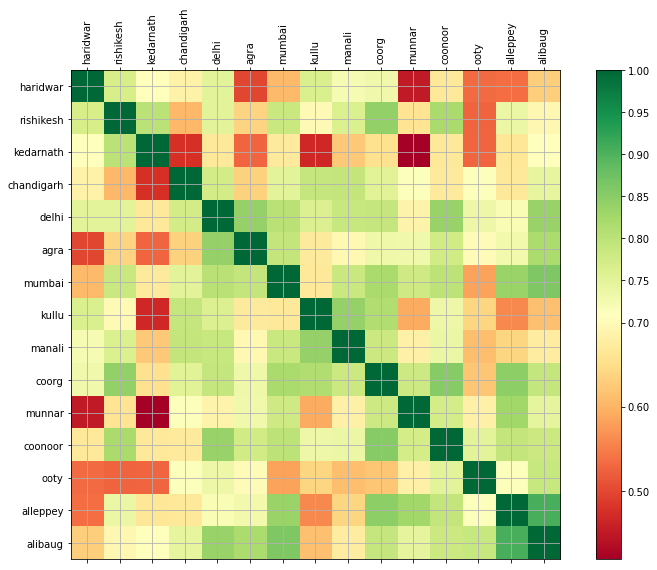

time: 393 ms (started: 2021-05-05 14:54:13 +00:00)


In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13,9))
cax = ax.matshow(similarity_scores, interpolation='nearest',cmap='RdYlGn')
ax.grid(True)
plt.xticks(range(len(queries)), queries, rotation=90);
plt.yticks(range(len(queries)), queries);
fig.colorbar(cax, ticks=[  0.5, 0.6, 0.7, .75,.80,0.85,0.90,0.95,1])
plt.show()